# Week10: GAN

## 实验要求与基本流程

### 实验要求
1. 完成上一节实验课内容，理解GAN(Generative Adversarial Networks,生成对抗网络)的原理与训练方法.
2. 结合理论课内容, 了解CGAN, pix2pix等模型基本结构和主要作用.
2. 阅读实验指导书的实验内容,按照提示运行以及补充实验代码,或者简要回答问题.提交作业时,保留实验结果.


### 实验流程
* CGAN
* pix2pix

## CGAN(Conditional GAN)
由上节课的内容可以看到,GAN可以用来生成接近真实的图片,但普通的GAN太过自由而不可控了,而CGAN(Conditional GAN)是一种带条件约束的GAN，在生成模型(D)和判别模型(G)的建模中均引入条件变量.这些条件变量可以基于多种信息，例如类别标签，用于图像修复的部分数据等等.在这个接下来这个CGAN中我们引入类别标签作为G和D的条件变量.

在下面的CGAN网络结构(与上节课展示的DCGAN模型相似)中,与之前的模型最大的不同是在G和D的输入中加入了类别标签labels,在G中,labels(用one-hot向量表示,如有3个类(0/1/2),第2类的one-hot向量为\[0, 0, 1\])和原来的噪声z一起输入到第一层全连接层中,在D中,labels和输入图片一起输入到卷积层中,labels中每个label用大小为(class_num,image_size,image_size)的张量表示,其正确类别的channel全为1,其余channel全为0.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from utils import initialize_weights
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32, class_num=10):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32, class_num=10):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim + self.class_num, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

In [ ]:
from utils import initialize_weights
class DCGenerator(nn.Module):
    def __init__(self, image_size=32, latent_dim=64, output_channel=1, class_num=3):
        super(DCGenerator, self).__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.output_channel = output_channel
        self.class_num = class_num
        
        self.init_size = image_size // 8
        
        # fc: Linear -> BN -> ReLU
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + class_num, 512 * self.init_size ** 2),
            nn.BatchNorm1d(512 * self.init_size ** 2),
            nn.ReLU(inplace=True)
        )
            
        # deconv: ConvTranspose2d(4, 2, 1) -> BN -> ReLU -> 
        #         ConvTranspose2d(4, 2, 1) -> BN -> ReLU -> 
        #         ConvTranspose2d(4, 2, 1) -> Tanh
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, output_channel, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, z, labels):
        """
        z : noise vector
        labels : one-hot vector 
        """
        input_ = torch.cat((z, labels), dim=1)
        out = self.fc(input_)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.deconv(out)
        return img


class DCDiscriminator(nn.Module):
    def __init__(self, image_size=32, input_channel=1, class_num=3, sigmoid=True):
        super(DCDiscriminator, self).__init__()
        self.image_size = image_size
        self.input_channel = input_channel
        self.class_num = class_num
        
        self.fc_size = image_size // 8
        
        # conv: Conv2d(3,2,1) -> LeakyReLU 
        #       Conv2d(3,2,1) -> BN -> LeakyReLU 
        #       Conv2d(3,2,1) -> BN -> LeakyReLU 
        
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel + class_num, 128, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        # fc: Linear -> Sigmoid
        self.fc = nn.Sequential(
            nn.Linear(512 * self.fc_size * self.fc_size, 1),
        )
        if sigmoid:
            self.fc.add_module('sigmoid', nn.Sigmoid())
        initialize_weights(self)
        
        
#       model : img -> conv1_1 ->
#               labels -> conv1_2 ->
#               (img U labels) -> conv

#         self.conv1_1 = nn.Sequential(nn.Conv2d(input_channel, 64, 3, 2, 1),
#                                      nn.BatchNorm2d(64))
#         self.conv1_2 = nn.Sequential(nn.Conv2d(class_num, 64, 3, 2, 1),
#                                      nn.BatchNorm2d(64))
        
#         self.conv = nn.Sequential(
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(128, 256, 3, 2, 1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(256, 512, 3, 2, 1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2),
#         )

        
        

    def forward(self, img, labels):
        """
        img : input image
        labels : (batch_size, class_num, image_size, image_size)
                the i-th channel is filled with 1, and others is filled with 0.
        """
#         img = self.conv1_1(img)
#         labels = self.conv1_2(labels)
        input_ = torch.cat((img, labels), dim=1)
        out = self.conv(input_)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)

        return out

### 数据集
我们使用我们熟悉的MNIST手写体数据集来训练我们的CGAN,我们同样提供了一个简化版本的数据集来加快我们的训练速度,与上次的数据集不一样的是,这次的数据集包含0到9共10类的手写数字,每类各200张,共2000张.图片同样为28\*28的单通道灰度图(我们将其resize到32\*32).下面是加载mnist数据集的代码.

In [ ]:
def load_mnist_data():
    """
    load mnist(0,1,2) dataset 
    """
    
    transform = torchvision.transforms.Compose([
        # transform to 1-channel gray image since we reading image in RGB mode
        transforms.Grayscale(1),
        # resize image from 28 * 28 to 32 * 32
        transforms.Resize(32),
        transforms.ToTensor(),
        # normalize with mean=0.5 std=0.5
        transforms.Normalize(mean=(0.5, ), 
                             std=(0.5, ))
        ])
    
    train_dataset = torchvision.datasets.ImageFolder(root='./data/mnist', transform=transform)
    
    return train_dataset

接下来让我们查看一下各个类上真实的手写体数据集的数据吧.(运行一下2个cell的代码,无需理解)

In [ ]:
def denorm(x):
    # denormalize
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
from utils import show
"""
you can pass code in this cell
"""
# show mnist real data
train_dataset = load_mnist_data()
images = []
for j in range(5):
    for i in range(10):
        images.append(train_dataset[i * 200 + j][0])
show(torchvision.utils.make_grid(denorm(torch.stack(images)), nrow=10))

训练部分的代码代码与之前相似, 不同的地方在于要根据类别生成y_vec(one-hot向量如类别2对应\[0,1,0,0,0,0,0,0,0,0\])和y_fill(大小为(class_num, image_size, image_size)正确的类别的channel全为1,其他channel全为0),分别输入G和D作为条件变量.其他训练过程与普通的GAN相似.

In [ ]:
def train(trainloader, G, D, G_optimizer, D_optimizer, loss_func, device, z_dim, class_num):
    """
    train a GAN with model G and D in one epoch
    Args:
        trainloader: data loader to train
        G: model Generator
        D: model Discriminator
        G_optimizer: optimizer of G(etc. Adam, SGD)
        D_optimizer: optimizer of D(etc. Adam, SGD)
        loss_func: Binary Cross Entropy(BCE) or MSE loss function
        device: cpu or cuda device
        z_dim: the dimension of random noise z
    """
    # set train mode
    D.train()
    G.train()
    
    D_total_loss = 0
    G_total_loss = 0
    
    
    for i, (x, y) in enumerate(trainloader):
        x = x.to(device)
        batch_size_ = x.size(0)
        image_size = x.size(2)
        
        # real label and fake label
        real_label = torch.ones(batch_size_, 1).to(device)
        fake_label = torch.zeros(batch_size_, 1).to(device)
        
        # y_vec: (batch_size, class_num) one-hot vector, for example, [0,0,0,0,1,0,0,0,0,0] (label: 4)
        y_vec = torch.zeros(batch_size_, class_num).scatter_(1, y.type(torch.LongTensor).unsqueeze(1), 1).to(device)
        # y_fill: (batch_size, class_num, image_size, image_size)
        # y_fill: the i-th channel is filled with 1, and others is filled with 0.
        y_fill = y_vec.unsqueeze(2).unsqueeze(3).expand(batch_size_, class_num, image_size, image_size)
        
        z = torch.rand(batch_size_, z_dim).to(device)

        # update D network
        # D optimizer zero grads
        D_optimizer.zero_grad()
        
        # D real loss from real images
        d_real = D(x, y_fill)
        d_real_loss = loss_func(d_real, real_label)
        
        # D fake loss from fake images generated by G
        g_z = G(z, y_vec)
        d_fake = D(g_z, y_fill)
        d_fake_loss = loss_func(d_fake, fake_label)
        
        # D backward and step
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_optimizer.step()

        # update G network
        # G optimizer zero gradsinput_dim=100, output_dim=1, input_size=32, class_num=10
        G_optimizer.zero_grad()
        
        # G loss
        g_z = G(z, y_vec)
        d_fake = D(g_z, y_fill)
        g_loss = loss_func(d_fake, real_label)
        
        # G backward and step
        g_loss.backward()
        G_optimizer.step()
        
        D_total_loss += d_loss.item()
        G_total_loss += g_loss.item()
        
    
    return D_total_loss / len(trainloader), G_total_loss / len(trainloader)

visualize_results和run_gan的代码不再详细说明.

In [ ]:
def visualize_results(G, device, z_dim, class_num, class_result_size=5):
    G.eval()
    
    z = torch.rand(class_num * class_result_size, z_dim).to(device)
    
    y = torch.LongTensor([i for i in range(class_num)] * class_result_size)
    y_vec = torch.zeros(class_num * class_result_size, class_num).scatter_(1, y.unsqueeze(1), 1).to(device)
    g_z = G(z, y_vec)
    
    show(torchvision.utils.make_grid(denorm(g_z.detach().cpu()), nrow=class_num))

In [ ]:
def run_gan(trainloader, G, D, G_optimizer, D_optimizer, loss_func, n_epochs, device, latent_dim, class_num):
    d_loss_hist = []
    g_loss_hist = []

    for epoch in range(n_epochs):
        d_loss, g_loss = train(trainloader, G, D, G_optimizer, D_optimizer, loss_func, device, 
                               latent_dim, class_num)
        print('Epoch {}: Train D loss: {:.4f}, G loss: {:.4f}'.format(epoch, d_loss, g_loss))

        d_loss_hist.append(d_loss)
        g_loss_hist.append(g_loss)

        if epoch == 0 or (epoch + 1) % 10 == 0:
            visualize_results(G, device, latent_dim, class_num) 
    
    return d_loss_hist, g_loss_hist

下面尝试训练一下我们的CGAN吧.

In [ ]:
# hyper params

# z dim
latent_dim = 100

# class number
class_num = 10

# image size and channel
image_size=32
image_channel=1

# Adam lr and betas
learning_rate = 0.0002
betas = (0.5, 0.999)

# epochs and batch size
n_epochs = 200
batch_size = 32

# device : cpu or cuda:0/1/2/3
device = torch.device('cuda:0')

# mnist dataset and dataloader
train_dataset = load_mnist_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# use BCELoss as loss function
bceloss = nn.BCELoss().to(device)

# G and D model
G = DCGenerator(image_size=image_size, latent_dim=latent_dim, output_channel=image_channel, class_num=class_num)
D = DCDiscriminator(image_size=image_size, input_channel=image_channel, class_num=class_num)
G.to(device)
D.to(device)

print(D)
print(G)

# G and D optimizer, use Adam or SGD
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

In [ ]:
d_loss_hist, g_loss_hist = run_gan(trainloader, G, D, G_optimizer, D_optimizer, bceloss, 
                                   n_epochs, device, latent_dim, class_num)

In [ ]:
from utils import loss_plot
loss_plot(d_loss_hist, g_loss_hist)

**作业** : 在D中,可以将输入图片和labels分别通过两个不同的卷积层然后在维度1合并(通道上合并),再一起送去接下来的网络结构.网络部分结构已经在DCDiscriminator中写好,请在修改forward函数完成上述功能并再次使用同样的数据集训练CGAN.

## Image-image translation
下面介绍一个使用CGAN来做Image-to-Image Translation的模型--pix2pix。


本次实验使用的是Facade数据集，由于数据集的特殊性，一张图片包括两部分，如下图，左半边为groundtruth，右半边为轮廓，我们需要重写数据集的读取类，下面这个cell是就是用来读取数据集。
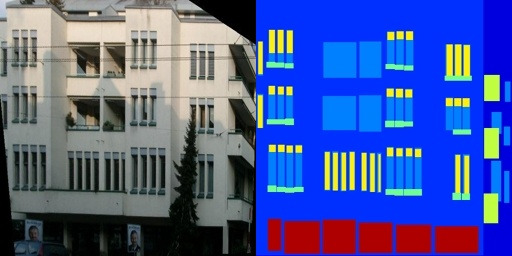

In [ ]:
import glob
import random
import os
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms


class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms_
        # read image
        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.*")))

    def __getitem__(self, index):
        # crop image,the left half if groundtruth image, and the right half is outline of groundtruth.
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_B = img.crop((0, 0, w / 2, h))
        img_A = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            # revese the image by 50%
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

生成网络G,一个Encoder-Decoder模型，借鉴了U-Net结构，所谓的U-Net是将第i层拼接到第n-i层，这样做是因为第i层和第n-i层的图像大小是一致的。
判别网络D,Pix2Pix中的D被实现为Patch-D，所谓Patch，是指无论生成的图像有多大，将其切分为多个固定大小的Patch输入进D去判断。

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch


def weights_init_normal(m):
    '''
        initial the weight in normal distribution
    '''
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           U-NET
##############################


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            # when baych-size is 1, BN is replaced by instance normalization
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            # when baych-size is 1, BN is replaced by instance normalization
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 256, dropout=0.5)
        self.down5 = UNetDown(256, 256, dropout=0.5)
        self.down6 = UNetDown(256, 256, normalize=False, dropout=0.5)

        self.up1 = UNetUp(256, 256, dropout=0.5)
        self.up2 = UNetUp(512, 256)
        self.up3 = UNetUp(512, 256)
        self.up4 = UNetUp(512, 128)
        self.up5 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)# 32x32
        d2 = self.down2(d1)#16x16
        d3 = self.down3(d2)#8x8
        d4 = self.down4(d3)#4x4
        d5 = self.down5(d4)#2x2
        d6 = self.down6(d5)#1x1
        u1 = self.up1(d6, d5)#2x2
        u2 = self.up2(u1, d4)#4x4
        u3 = self.up3(u2, d3)#8x8
        u4 = self.up4(u3, d2)#16x16
        u5 = self.up5(u4, d1)#32x32

        return self.final(u5)#64x64


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                # when baych-size is 1, BN is replaced by instance normalization
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),#32x32
            *discriminator_block(64, 128),#16x16
            *discriminator_block(128, 256),#8x8
            *discriminator_block(256, 256),#4x4
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(256, 1, 4, padding=1, bias=False)#4x4
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets


import torch.nn as nn
import torch.nn.functional as F
import torch

下面这个函数用来保存轮廓图，生成图片，groundtruth，以作对比。

In [ ]:
from utils import show
def sample_images(dataloader, G, device):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(dataloader))
    real_A = imgs["A"].to(device)
    real_B = imgs["B"].to(device)
    fake_B = G(real_A)
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
    show(torchvision.utils.make_grid(img_sample.cpu().data, nrow=5, normalize=True))

接着定义一些超参数，损失函数和优化器

In [ ]:
# hyper param
n_epochs = 200
batch_size = 8
lr = 0.0002
decay_epoch = 100
img_size = 64
channels = 3
device = torch.device('cuda:0')
betas = (0.5, 0.999)
# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 10

In [ ]:
# Loss functions
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_pixelwise = torch.nn.L1Loss().to(device)

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_size // 16, img_size // 16)

# Initialize generator and discriminator
G = GeneratorUNet().to(device)
D = Discriminator().to(device)
G.apply(weights_init_normal)
D.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)

# Configure dataloaders
transforms_ = transforms.Compose([
    transforms.Resize((img_size, img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


dataloader = DataLoader(
    ImageDataset("./data/facades", transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

val_dataloader = DataLoader(
    ImageDataset("./data/facades", transforms_=transforms_, mode="val"),
    batch_size=10,
    shuffle=True,
    num_workers=1,
)

对于pix2pix的loss function，包括CGAN的loss，加上L1Loss，其中L1Loss之前有一个系数Lambdam，用于调节两者之间的权重。

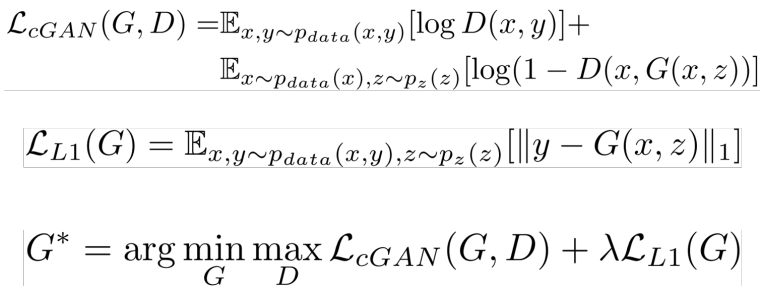

下面开始训练pix2pix。

In [ ]:
for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader):

        #  G:B -> A
        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        # Adversarial ground truths
        real_label = torch.ones((real_A.size(0), *patch)).to(device)
        fake_label = torch.zeros((real_A.size(0), *patch)).to(device)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = G(real_A)
        pred_fake = D(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, real_label)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = D(real_B, real_A)
        loss_real = criterion_GAN(pred_real, real_label)

        # Fake loss
        pred_fake = D(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake_label)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

    # Print log
    print(
        "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f]"
        % (
            epoch,
            n_epochs,
            i,
            len(dataloader),
            loss_D.item(),
            loss_G.item(),
            loss_pixel.item(),
            loss_GAN.item(),
        )
    )

    # If at sample interval save image
    if epoch == 0 or (epoch + 1) % 5 == 0:
        sample_images(val_dataloader, G, device)

作业：分别实验只用CGAN Loss和只用L1 Loss的情况下pix2pix的训练效果。